> This notebook contains code to generate the forward velocity of the car given the radar scans and the extrinsic calibration matrix.

Python Packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

from scipy.stats import chi2
from scipy.spatial.transform import Rotation as Rot
from tqdm.autonotebook import tqdm;
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error

/tmp/ipykernel_12153/921915617.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm;


In [2]:
# %matplotlib qt

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

warnings.filterwarnings('ignore') 

Reading the radar data:

In [3]:
radar = pd.read_csv("../data/2022-09-05-16-29-36/front_left.csv")

In [4]:
radar.head()

,Time,x,y,z,azimuth,elevation,rcs,snr,speed
0,1.662410e+09,8.033162,3.904160,0.712347,0.452389,0.079587,-15.0,18.5,-0.08
1,1.662410e+09,5.780010,-6.986833,-1.775738,-0.879646,-0.193382,4.2,24.5,-0.04
2,1.662410e+09,8.321154,4.188744,0.906872,0.466352,0.097040,-15.0,25.5,-0.12
3,1.662410e+09,8.611664,4.215084,1.000961,0.455182,0.104022,-10.2,30.5,0.00
4,1.662410e+09,9.318254,3.332749,0.685075,0.343481,0.069115,-15.0,27.0,0.00


In [5]:
ref = pd.read_csv("../data/2022-09-05-16-29-36/inspvax2.csv")

In [6]:
ref['speed'] = np.sqrt(np.square(ref.loc[:,'east_velocity'].to_numpy()) +
                       np.square(ref.loc[:,'north_velocity'].to_numpy()) +
                       np.square(ref.loc[:,'up_velocity'].to_numpy()))

Propagating uncertainties:

In [7]:
ve = ref["east_velocity"].to_numpy()
vn = ref["north_velocity"].to_numpy()
vu = ref["up_velocity"].to_numpy()
ve_contribution = ve / np.sqrt(ve**2 + vn**2 + vu**2)
vn_contribution = vn / np.sqrt(ve**2 + vn**2 + vu**2)
vu_contribution = vu / np.sqrt(ve**2 + vn**2 + vu**2)
std_ref_speed = np.sqrt((ve_contribution * ref["east_velocity_stdev"].to_numpy())**2 +
                        (vn_contribution * ref["north_velocity_stdev"].to_numpy())**2 +
                        (vu_contribution * ref["up_velocity_stdev"].to_numpy())**2)
ref['std'] = std_ref_speed

In [8]:
grouped = radar.groupby(['Time'])

Checking average speed of each scan:

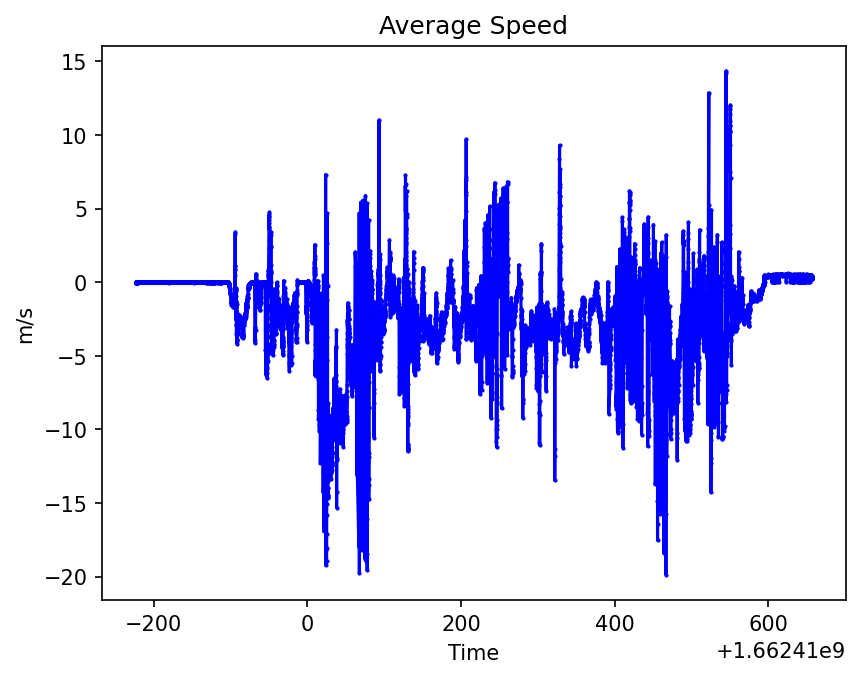

In [9]:
groupedS = radar.groupby(['Time']).mean()
plt.plot(groupedS.index, groupedS.speed, '-ob', markersize=1)
plt.title('Average Speed')
plt.xlabel('Time')
plt.ylabel('m/s')
plt.show();

Aligning Radar with Reference by getting the closest timestamp:

In [10]:
all_data = []
for t, group in grouped:
    temp = np.abs(ref['Time'].to_numpy() - t)
    id = np.argmin(temp)
    if temp[id] < 0.02:
        if group.shape[0] >= 3:
            all_data.append([*t, group.loc[:,['azimuth','elevation','speed']].to_numpy(), [ref['speed'].iat[id],ref['std'].iat[id]]])

Estimating the Radar Velocity:

In [11]:
model = RANSACRegressor(min_samples=3,
                        max_trials=100,
                        random_state=17)

In [12]:
radar_data = []
delta_t = []
pbar = tqdm(total=len(all_data))
for t, detections, ref in all_data:
    y = detections[:,2]
    Ai = (np.cos(detections[:,1]) * np.cos(detections[:,0])).reshape(-1,1)
    Aj = (np.cos(detections[:,1]) * np.sin(detections[:,0])).reshape(-1,1)
    Ak = (np.sin(detections[:,1])).reshape(-1,1)
    A = np.hstack((Ai,Aj,Ak))
    tic = time.time()
    try:
        model.fit(A,y)
        x = model.estimator_.coef_
    except:
        x = [np.nan,np.nan,np.nan]
    toc = time.time()
    delta_t.append(toc-tic)
    radar_data.append([t,x,ref])
    pbar.update(n=1)

  0%|          | 0/9205 [00:00<?, ?it/s]

In [13]:
print(f'Mean inference time: {np.mean(delta_t)} s')

Mean inference time: 0.0034732483185742746 s


In [14]:
# radar_data

Using calibration made in Kingston:

Transformation matrix from front right radar to pwrpak7. 

In [15]:
# R = Rot.from_euler('xyz', [0.04782, 0.00323, -0.73950], degrees=False)
# t = np.array([0.25252, -0.51511, -0.34276]) + np.array([0.480, -0.115, 0.395])
# T = np.eye(4)
# T[0:3,0:3] = R.as_matrix()
# T[0:3,3]   = t
# T

Transformation matrix from front left radar to pwrpak7. 

In [16]:
R = Rot.from_euler('xyz', [-0.07209, -0.03804, 0.86847], degrees=False)

Transformation matrix from rear right radar to pwrpak7. 

In [17]:
# R = Rot.from_euler('xyz', [0.04212, 0.00280, -2.30320], degrees=False)

Transformation matrix from rear left radar to pwrpak7. 

In [18]:
# R = Rot.from_euler('xyz', [0.07741, -0.04312, 2.38532], degrees=False)

In [19]:
body_data = []
pbar = tqdm(total=len(radar_data))
for t, radar, ref in radar_data:
    spd = R.as_matrix().dot(radar)
    spd = np.linalg.norm(spd)
    body_data.append([t,ref[0],spd])
    pbar.update(n=1)

  0%|          | 0/9205 [00:00<?, ?it/s]

In [29]:
body_data = np.array(body_data)

In [30]:
outliers = body_data[:,2] > 5e3

In [31]:
body_data = body_data[~outliers,:]

In [32]:
idx = np.isnan(body_data[:,2])

In [33]:
# alpha = 0.003
# s1 = chi2.isf(alpha, 1)
# sigma = np.sqrt(s1*np.square(body_data[:,-1]))

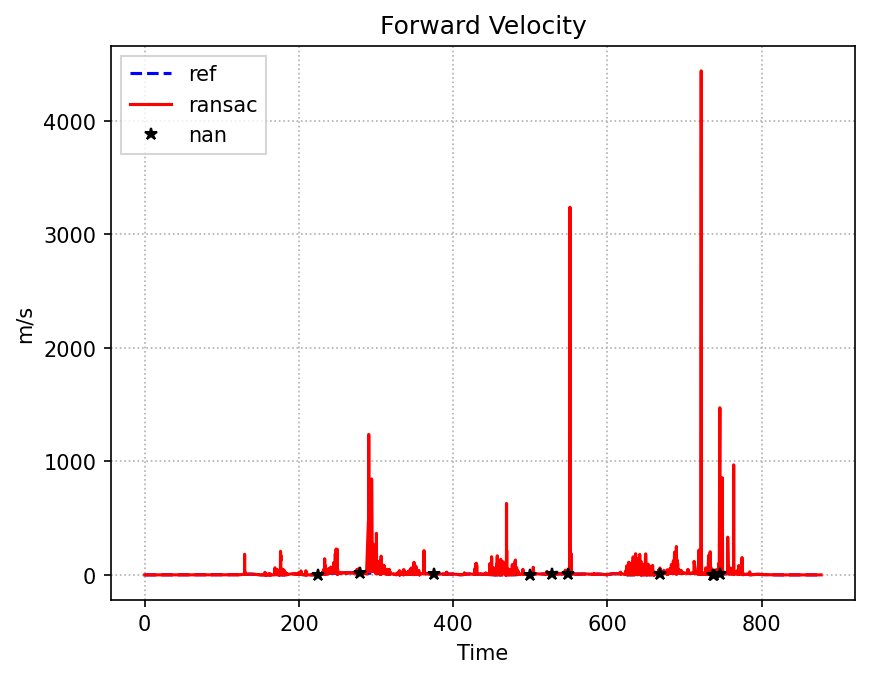

In [34]:
# plt.fill_between(body_data[:,0]-body_data[0,0], -sigma+body_data[:,1], sigma+body_data[:,1], color='b', alpha=0.2, label=str(100*(1-alpha)) + '% Confidence Bounds')
plt.plot(body_data[:,0]-body_data[0,0],body_data[:,1],'--b',label='ref')
plt.plot(body_data[~idx,0]-body_data[0,0],body_data[~idx,2],'r',label='ransac')
plt.plot(body_data[idx,0]-body_data[0,0],body_data[idx,1],'*k',label='nan')
# plt.axis('equal')
plt.legend(fancybox=False)
plt.xlabel('Time')
plt.ylabel('m/s')
plt.title('Forward Velocity')
plt.grid(linestyle=':')
plt.show()

In [35]:
print(f'RMSE: {mean_squared_error(body_data[~idx,1], body_data[~idx,2], squared=False)} m/s')

RMSE: 68.04334172071744 m/s


Save new csv file with transformed data:

In [27]:
# df = pd.DataFrame(body_data,columns=['Time','ref_speed','speed'])

In [28]:
# df.to_csv('../ransac/2022-09-05-16-29-36/front-right.csv',index=False)